# Kernel CCA (KCCA)

This algorithm runs KCCA on two views of data. The kernel implementations, parameter 'ktype', are linear, polynomial and gaussian. Polynomial kernel has two parameters: 'constant', 'degree'. Gaussian kernel has one parameter: 'sigma'.

Useful information, like canonical correlations between transformed data and statistical tests for significance of these correlations can be computed using the get_stats() function of the KCCA object.

When initializing KCCA, you can also initialize the following parameters: the number of canonical components 'n_components', the regularization parameter 'reg', the decomposition type 'decomposition', and the decomposition method 'method'. There are two decomposition types: 'full' and 'icd'. In some cases, ICD will run faster than the full decomposition at the cost of performance. The only method as of now is 'kettenring-like'.


In [1]:
import numpy as np
import sys
sys.path.append("../../..")

from mvlearn.embed.kcca import KCCA
from mvlearn.plotting.plot import crossviews_plot
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

Function creates Xs, a list of two views of data with a linear relationship, polynomial relationship (2nd degree) and a gaussian (sinusoidal) relationship.

In [2]:
def make_data(kernel, N):
    # # # Define two latent variables (number of samples x 1)
    latvar1 = np.random.randn(N,)
    latvar2 = np.random.randn(N,)
    
    # # # Define independent components for each dataset (number of observations x dataset dimensions)
    indep1 = np.random.randn(N, 4)
    indep2 = np.random.randn(N, 5)
    
    if kernel == "linear":
        x = 0.25*indep1 + 0.75*np.vstack((latvar1, latvar2, latvar1, latvar2)).T
        y = 0.25*indep2 + 0.75*np.vstack((latvar1, latvar2, latvar1, latvar2, latvar1)).T
        
        return [x,y]
    
    elif kernel == "poly":
        x = 0.25*indep1 + 0.75*np.vstack((latvar1**2, latvar2**2, latvar1**2, latvar2**2)).T
        y = 0.25*indep2 + 0.75*np.vstack((latvar1, latvar2, latvar1, latvar2, latvar1)).T
        
        return [x,y]
    
    elif kernel == "gaussian":
        t = np.random.uniform(-np.pi, np.pi, N)
        e1 = np.random.normal(0, 0.05, (N,2))
        e2 = np.random.normal(0, 0.05, (N,2))
        
        x = np.zeros((N,2))
        x[:,0] = t
        x[:,1] = np.sin(3*t)
        x += e1
        
        y = np.zeros((N,2))
        y[:,0] = np.exp(t/4)*np.cos(2*t)
        y[:,1] = np.exp(t/4)*np.sin(2*t)
        y += e2
        
        return [x,y]

## Linear kernel implementation

Here we show how KCCA with a linear kernel can uncover the highly correlated latent distribution of the 2 views which are related with a linear relationship, and then transform the data into that latent space. We use an 80-20, train-test data split to develop the embedding. 

Also, we use statistical tests (Wilk's Lambda) to check the significance of the canonical correlations.

In [3]:
np.random.seed(1)
Xs = make_data('linear', 100)
Xs_train = [Xs[0][:80],Xs[1][:80]]
Xs_test = [Xs[0][80:],Xs[1][80:]]

kcca_l = KCCA(n_components = 4, reg = 0.01)
kcca_l.fit(Xs_train)
linearkcca = kcca_l.transform(Xs_test)

### Original Data Plotted

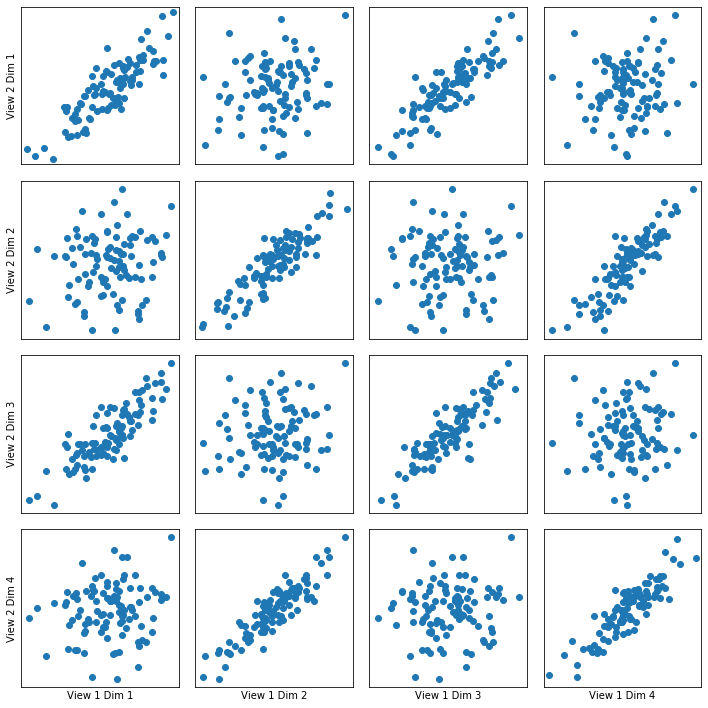

In [4]:
crossviews_plot(Xs, ax_ticks=False, ax_labels=True, equal_axes=True)

### Transformed Data Plotted

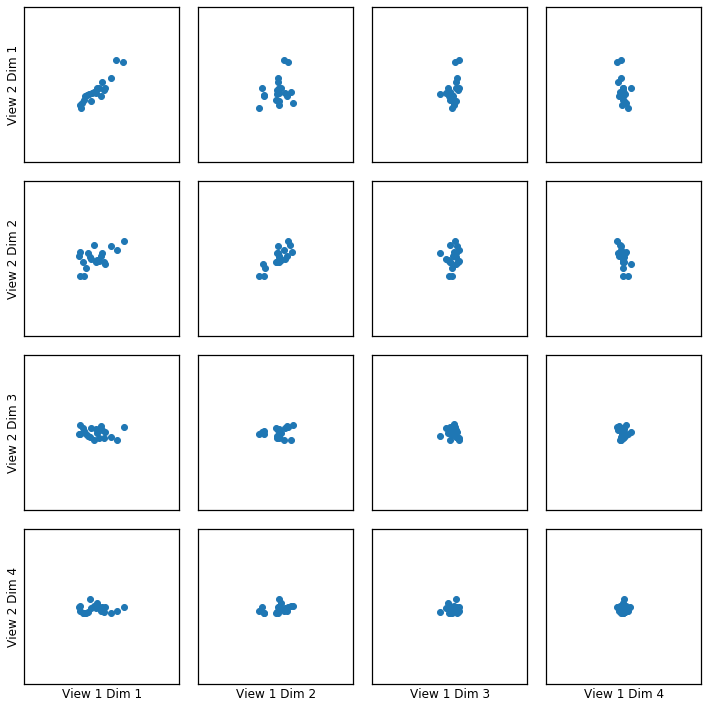

In [5]:
crossviews_plot(linearkcca, ax_ticks=False, ax_labels=True, equal_axes=True)

Now, we assess the canonical correlations achieved on the testing data, and the p-values for significance using a Wilk's Lambda test

In [6]:
stats = kcca_l.get_stats()

print("Below are the canonical correlations and the p-values of a Wilk's Lambda test for each components:")
print(stats['r'])
print(stats['pF'])


Below are the canonical correlations and the p-values of a Wilk's Lambda test for each components:
[ 0.92365255  0.79419444 -0.2453487  -0.0035017 ]
[0.00400878 0.25898906 0.99013426 0.99991417]


## Polynomial kernel implementation

Here we show how KCCA with a polynomial kernel can uncover the highly correlated latent distribution of the 2 views which are related with a polynomial relationship, and then transform the data into that latent space.

In [7]:
Xsp = make_data("poly", 150)
kcca_p = KCCA(ktype ="poly", degree = 2.0, n_components = 4, reg=0.001)
polykcca = kcca_p.fit_transform(Xsp)

### Original Data Plotted

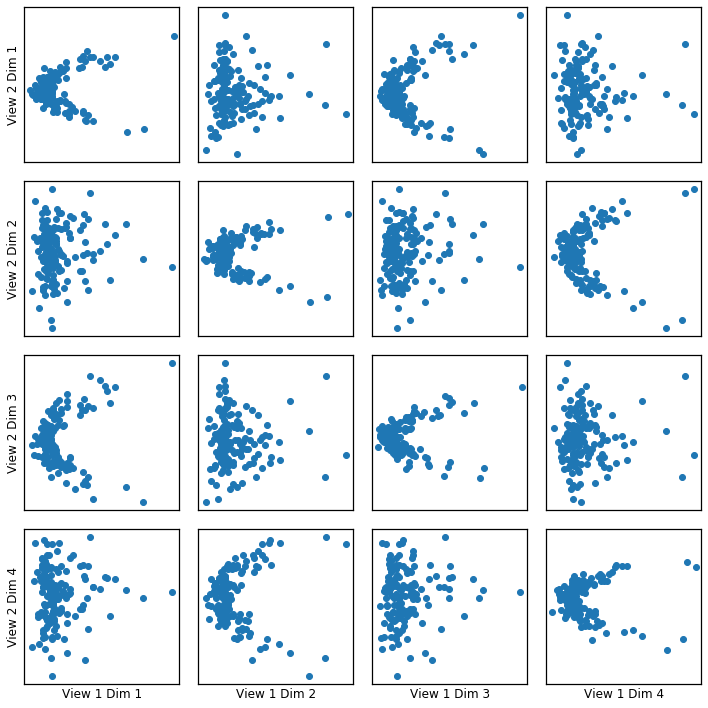

In [8]:
crossviews_plot(Xsp, ax_ticks=False, ax_labels=True, equal_axes=True)

### Transformed Data Plotted

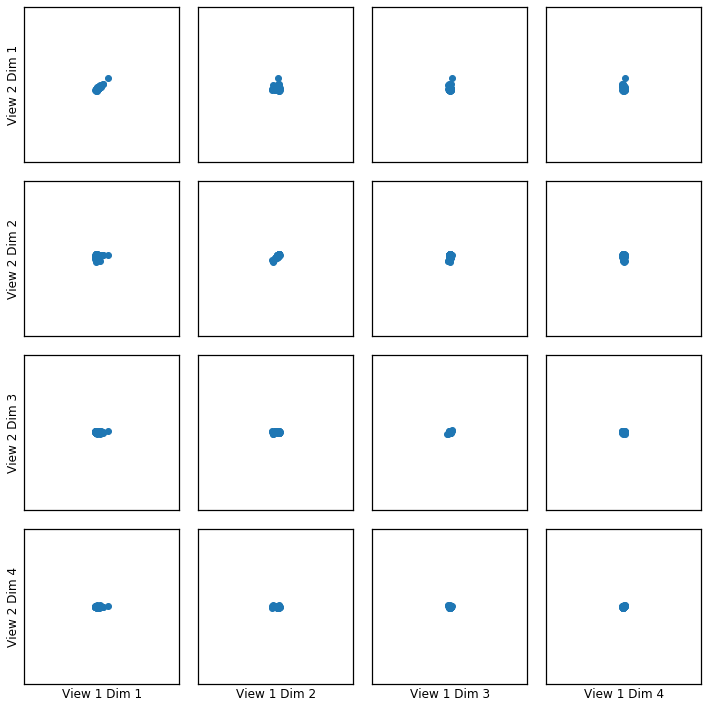

In [9]:
crossviews_plot(polykcca, ax_ticks=False, ax_labels=True, equal_axes=True)

Now, we assess the canonical correlations achieved on the testing data

In [10]:
stats = kcca_p.get_stats()

print("Below are the canonical correlations for each components:")
print(stats['r'])

Below are the canonical correlations for each components:
[0.96738396 0.94500285 0.63334922 0.57870821]


## Gaussian Kernel Implementation

Here we show how KCCA with a gaussian kernel can uncover the highly correlated latent distribution of the 2 views which are related with a sinusoidal relationship, and then transform the data into that latent space. 

In [11]:
Xsg = make_data("gaussian", 100)
Xsg_train = [Xsg[0][:20],Xsg[1][:20]]
Xsg_test = [Xsg[0][20:],Xsg[1][20:]]

In [12]:
kcca_g = KCCA(ktype ="gaussian", sigma = 1.0, n_components = 2, reg = 0.01)
kcca_g.fit(Xsg)
gausskcca = kcca_g.transform(Xsg)

### Original Data Plotted

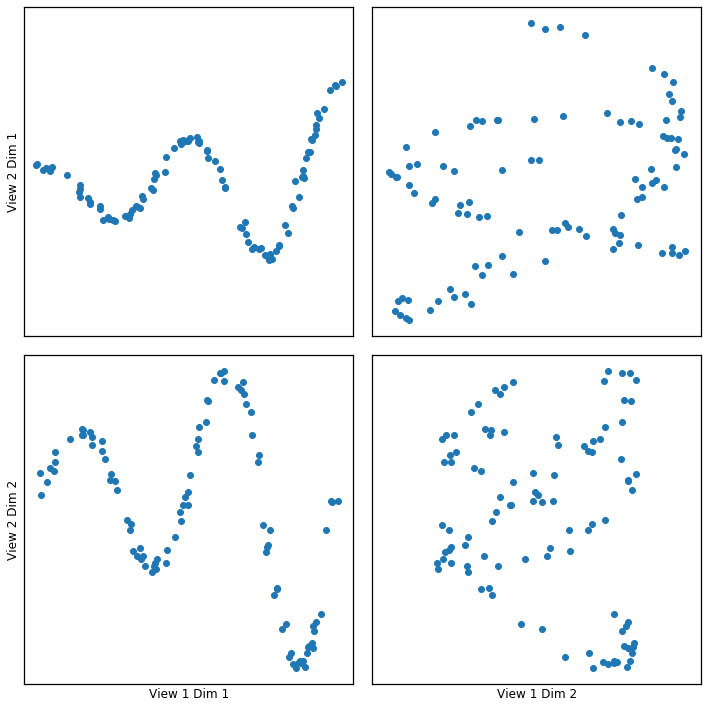

In [13]:
crossviews_plot(Xsg, ax_ticks=False, ax_labels=True, equal_axes=True)

### Transformed Data Plotted

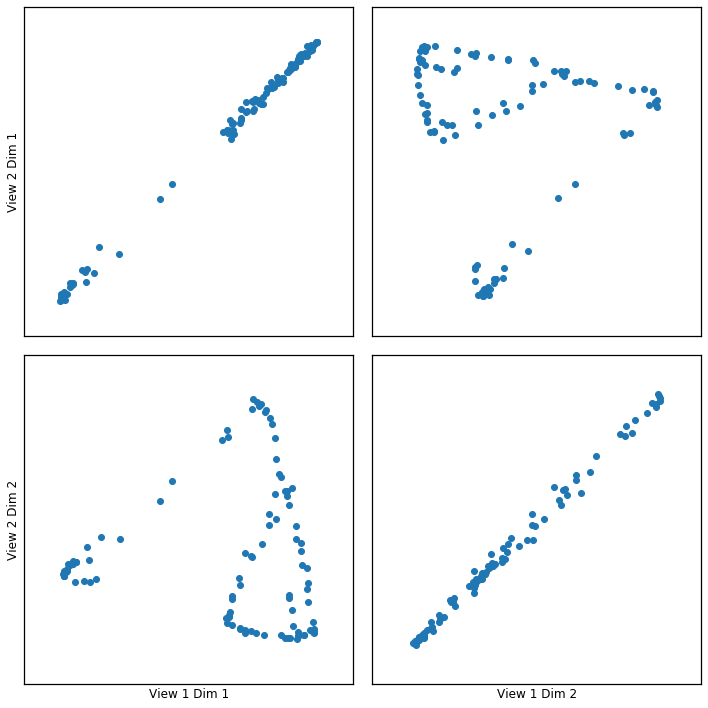

In [14]:
crossviews_plot(gausskcca, ax_ticks=False, ax_labels=True, equal_axes=True)

Now, we assess the canonical correlations achieved on the testing data

In [15]:
stats = kcca_g.get_stats()

print("Below are the canonical correlations for each components:")
print(stats['r'])

Below are the canonical correlations for each components:
[0.99887253 0.99762762]
